Files in dataset directory:
['data.csv']
Loading dataset: /kaggle/input/india-air-quality-data/data.csv

Available columns:
Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')

Using NO2 column: no2

Transformation parameters -> a_r = 3.0, b_r = 0.8999999999999999
Epoch 0/3000 | D Loss: 1.4182 | G Loss: 0.7856
Epoch 500/3000 | D Loss: 1.1047 | G Loss: 0.8860
Epoch 1000/3000 | D Loss: 1.2266 | G Loss: 0.9227
Epoch 1500/3000 | D Loss: 1.3976 | G Loss: 0.6939
Epoch 2000/3000 | D Loss: 1.3623 | G Loss: 0.7515
Epoch 2500/3000 | D Loss: 1.3806 | G Loss: 0.6823


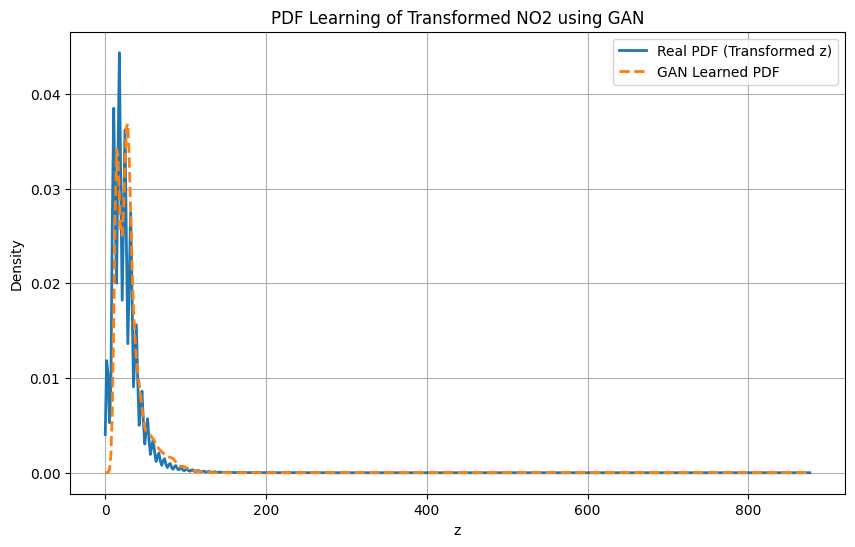

In [7]:
# ============================================================
# Learning an Unknown PDF using GAN (NO2 Concentration Data)
# ============================================================
# Robust Kaggle-compatible implementation
# Handles:
# - unknown CSV name
# - non-UTF8 encoding
# - inconsistent NO2 column naming
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

torch.manual_seed(42)
np.random.seed(42)



DATASET_DIR = "/kaggle/input/india-air-quality-data"

print("Files in dataset directory:")
print(os.listdir(DATASET_DIR))

csv_file = None
for file in os.listdir(DATASET_DIR):
    if file.endswith(".csv"):
        csv_file = os.path.join(DATASET_DIR, file)
        break

if csv_file is None:
    raise FileNotFoundError("No CSV file found in dataset directory!")

print(f"Loading dataset: {csv_file}")

df = pd.read_csv(csv_file, encoding="latin1", low_memory=False)


print("\nAvailable columns:")
print(df.columns)

no2_col = None
for col in df.columns:
    if "no2" in col.lower():
        no2_col = col
        break

if no2_col is None:
    raise ValueError("NO2 column not found in dataset!")

print(f"\nUsing NO2 column: {no2_col}")

x = df[no2_col].dropna().values.reshape(-1, 1)



r = 102313042  # University Roll Number

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print(f"\nTransformation parameters -> a_r = {a_r}, b_r = {b_r}")

def transform(x):
    return x + a_r * np.sin(b_r * x)

z = transform(x)

# Standardize for stable GAN training
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

z_tensor = torch.tensor(z_scaled, dtype=torch.float32)



class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


G = Generator()
D = Discriminator()


criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=0.001)
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

epochs = 3000
batch_size = 128



for epoch in range(epochs):

    idx = np.random.randint(0, len(z_tensor), batch_size)
    real_samples = z_tensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # ---- Train Discriminator ----
    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    d_loss = (
        criterion(D(real_samples), real_labels) +
        criterion(D(fake_samples.detach()), fake_labels)
    )

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # ---- Train Generator ----
    noise = torch.randn(batch_size, 1)
    generated = G(noise)
    g_loss = criterion(D(generated), real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")



with torch.no_grad():
    noise = torch.randn(10000, 1)
    z_fake_scaled = G(noise).numpy()

z_fake = scaler.inverse_transform(z_fake_scaled)



kde_real = gaussian_kde(z.flatten())
kde_fake = gaussian_kde(z_fake.flatten())

z_range = np.linspace(
    min(z.min(), z_fake.min()),
    max(z.max(), z_fake.max()),
    500
)



plt.figure(figsize=(10, 6))

plt.plot(z_range, kde_real(z_range),
         label="Real PDF (Transformed z)",
         linewidth=2)

plt.plot(z_range, kde_fake(z_range),
         label="GAN Learned PDF",
         linestyle="--",
         linewidth=2)

plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learning of Transformed NO2 using GAN")
plt.legend()
plt.grid(True)
plt.show()
